<a href="https://colab.research.google.com/github/chad-fisher/CRWA-Regional-Tree-Planting-and-Protection-Plan/blob/main/CodeNotebookInvasivesOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [1]:
#Need this because on a different computer :(
!pip install matplotlib_scalebar
!pip install contextily
!pip install wget
!pip install pyinaturalist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=3418a418fad550bbab439c5cb849f6b4af7f57762065b1d5380c211f5d4306c8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00


In [2]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import ee
import geemap
import geemap.foliumap as geemapf
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import wget
import zipfile
from datetime import datetime
import pyinaturalist
from scipy import ndimage
import urllib

In [3]:
#Authenticate to Earth Engine
ee.Authenticate()

<IPython.core.display.HTML object>

In [4]:
#Initialize earth engine project
ee.Initialize(project='ee-cefisher20')

<IPython.core.display.HTML object>

# Extracting watershed boundaries

In [6]:
#HUC codes from https://apps.nationalmap.gov/viewer/
Charles=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107' or huc10 == '0109000106'")
Charles_lower=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107'")
Charles_upper=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000106'")

<IPython.core.display.HTML object>

In [7]:
#Convert earth engine feature collections to geopandas data frames
Charles_gdf = ee.data.computeFeatures({
    'expression': Charles,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_gdf.crs = 'EPSG:4326'

Charles_lower_gdf = ee.data.computeFeatures({
    'expression': Charles_lower,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_lower_gdf.crs = 'EPSG:4326'

Charles_upper_gdf = ee.data.computeFeatures({
    'expression': Charles_upper,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_upper_gdf.crs = 'EPSG:4326'

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

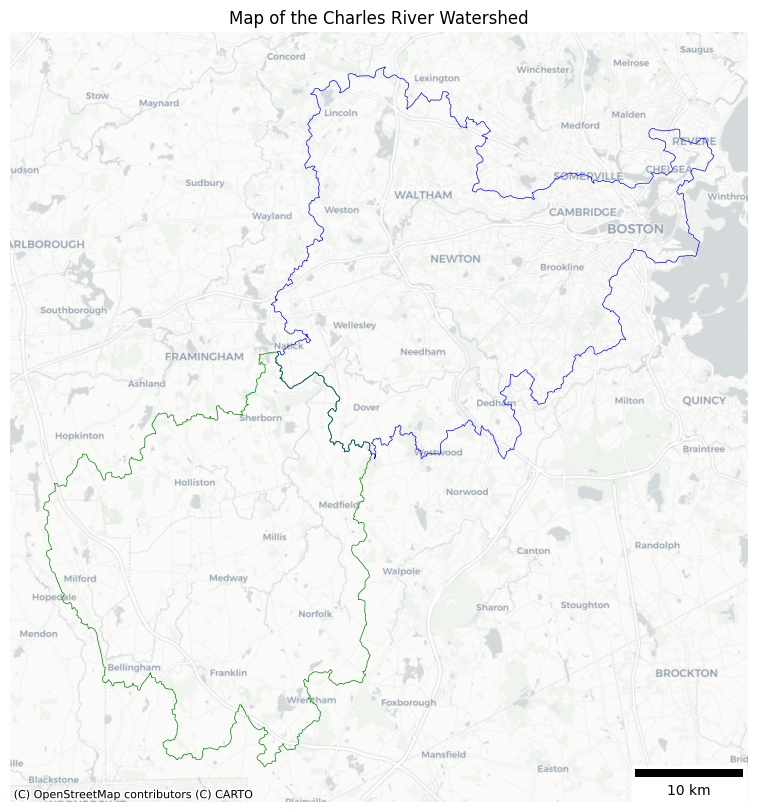

In [8]:
ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
plt.title("Map of the Charles River Watershed")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("Charles Watershed Maps.png")

In [9]:
#Create function to clip image to be used for clipping image collections
def Charclip(image):
    return image.clip(Charles)

<IPython.core.display.HTML object>

# Land Cover Maps

In [10]:
#Forest Areas
NLCD2019lc=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('landcover')
map_1 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(41)),name='Deciduous Forest',color='light green')
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(42)),name='Evergreen Forest',color='dark green')
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(43)),name='Mixed Forest',color='green')
map_1

#NLCD change maps for forest types, check out different times
#Add boundary to map

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7c105aa8a410>

In [11]:
#Impervious Cover
NLCD2019=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('impervious')
map_2 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
image_viz_params = {
    'bands': ['impervious'],
    'min': 0,
    'max': 100,
    'palette': 'plasma'
}
map_2.add_layer(NLCD2019, image_viz_params)
map_2

#NLCD data from previous years to see changes

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7c105aa8a1a0>

# Invasive Species Data Collection

In [12]:
#Extract Sentinel 2 bands and indices of interest
def extractBandsIndices(image):
    return image.select(['B2','B3','B4','B5_10m','B6_10m','B7_10m','B8','B8A_10m','B11_10m','B12_10m',
                         'NDVI','NBR','SAVI','RENDVI','EVI'])

<IPython.core.display.HTML object>

In [13]:
#Resample Sentinel 2 bands to 10 m
def resample10m(image):
    proj_10m=image.select('B4').projection()
    B5_res=image.select('B5').resample('bicubic').reproject(proj_10m).rename('B5_10m')
    B6_res=image.select('B6').resample('bicubic').reproject(proj_10m).rename('B6_10m')
    B7_res=image.select('B7').resample('bicubic').reproject(proj_10m).rename('B7_10m')
    B8A_res=image.select('B8A').resample('bicubic').reproject(proj_10m).rename('B8A_10m')
    B11_res=image.select('B11').resample('bicubic').reproject(proj_10m).rename('B11_10m')
    B12_res=image.select('B12').resample('bicubic').reproject(proj_10m).rename('B12_10m')
    return image.addBands([B5_res,B6_res,B7_res,B8A_res,B11_res,B12_res])

<IPython.core.display.HTML object>

In [14]:
#Add 5 vegetation indices of interest
def addIndices(image):
    NDVI = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    NBR = image.normalizedDifference(['B12_10m','B8']).rename('NBR')
    SAVI = image.expression(
        '1.5 * ((NIR - RED)) / (NIR + RED + 0.5)', {
            'NIR' : image.select('B8'),
            'RED' : image.select('B4'),
        }).rename('SAVI')
    RENDVI = image.normalizedDifference(['B6_10m','B5_10m']).rename('RENDVI')
    EVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR' : image.select('B8'),
            'RED' : image.select('B4'),
            'BLUE': image.select('B2')}).rename('EVI')
    return image.addBands([NDVI,NBR,SAVI,RENDVI,EVI])

<IPython.core.display.HTML object>

In [15]:
#Cloud mask function
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )
    return image.updateMask(mask).divide(10000)

<IPython.core.display.HTML object>

In [16]:
#Land cover mask function
def mask_forests(image):
    mask=(NLCD2019lc.eq(41).Or(NLCD2019lc.eq(42).Or(NLCD2019lc.eq(43))))
    return image.updateMask(mask)

<IPython.core.display.HTML object>

In [19]:
#Pre-processing sentinel-2 data
S2_All=ee.ImageCollection(("COPERNICUS/S2_SR_HARMONIZED")).filterDate('2019-01-01','2020-01-01').filterBounds(Charles.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)).map(mask_s2_clouds).map(Charclip).map(resample10m).map(addIndices).map(extractBandsIndices)

<IPython.core.display.HTML object>

In [20]:
S2_All_list = S2_All.toList(S2_All.size())

<IPython.core.display.HTML object>

In [50]:
S2_All.first().get('system:index')

<IPython.core.display.HTML object>

<ee.computedobject.ComputedObject object at 0x7c104cf47e50>

In [21]:
#Map of first image in collection
map_3 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_3.add_layer(ee.Image(S2_All_list.get(1)), {'bands':['B4','B3','B2'],'min':0,'max':0.2})
map_3

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7c105588ba30>

In [ ]:
NDVI=S2_All.select('NDVI')
NDVI_list=NDVI.toList(NDVI.size())
videoArgs = {
  'dimensions': 100,
  'region': Charles.geometry(),
  'framesPerSecond': 1,
  'crs': 'EPSG:3857',
  'min': 0,
  'max': 1,
  'format':'gif'
}

urllib.request.urlretrieve(NDVI.getVideoThumbURL(videoArgs),'NDVI2019_2020.gif')

In [30]:
NDVI=S2_All.select('NDVI')

<IPython.core.display.HTML object>

In [ ]:
NDVI_list=NDVI.toList(NDVI.size())

In [ ]:
map_4 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_4.add_layer(ee.Image(NDVI_list.get(0)))
map_4

In [ ]:
videoArgs = {
  'dimensions': 290,
  'region': Charles.geometry(),
  'framesPerSecond': 1,
  'crs': 'EPSG:3857',
  'min':0,
  'max':1,
  'format':'gif'
}
NDVI.getVideoThumbURL(videoArgs)

In [22]:
#List of invasive species of interest
# Japanese knotweed, Asian bittersweet, glossy buckthorn, euonymous, multiflora rose, cork tree, kudzu, porcelain berry
# https://www.massaudubon.org/nature-wildlife/invasive-plants-in-massachusetts
def get_obs(years,taxon_id):
  response=pyinaturalist.v1.observations.get_observations(year=years,taxon_id=taxon_id,geo=True,page='all',place_id=2)
  my_observations = pyinaturalist.Observation.from_json_list(response)
  df = pd.DataFrame(
      [
          {
              'latitude': o.location[0],
              'longitude': o.location[1],
              'date': o.observed_on.isoformat()
          }
          for o in my_observations
          if o.location
      ]
  )
  gdf = gpd.GeoDataFrame(
      df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
  )
  return gdf

<IPython.core.display.HTML object>

In [23]:
# https://nbviewer.org/gist/perrygeo/c426355e40037c452434
def density_heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.gaussian_filter(logheatmap, smoothing, mode='nearest')

    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

<IPython.core.display.HTML object>

In [24]:

years=[2020]
knotweed=914922
bittersweet=64540
buckthorn=55972
euonymus=117433
multiflora=78882
corktree=166636
porcelain=204237
kudzu=62671
barberry=58727

knot_gdf=get_obs(years,knotweed)
bitt_gdf=get_obs(years,bittersweet)
buck_gdf=get_obs(years,buckthorn)
euon_gdf=get_obs(years,euonymus)
mult_gdf=get_obs(years,multiflora)
cork_gdf=get_obs(years,corktree)
porc_gdf=get_obs(years,porcelain)
kudz_gdf=get_obs(years,kudzu)
barb_gdf=get_obs(years,barberry)

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


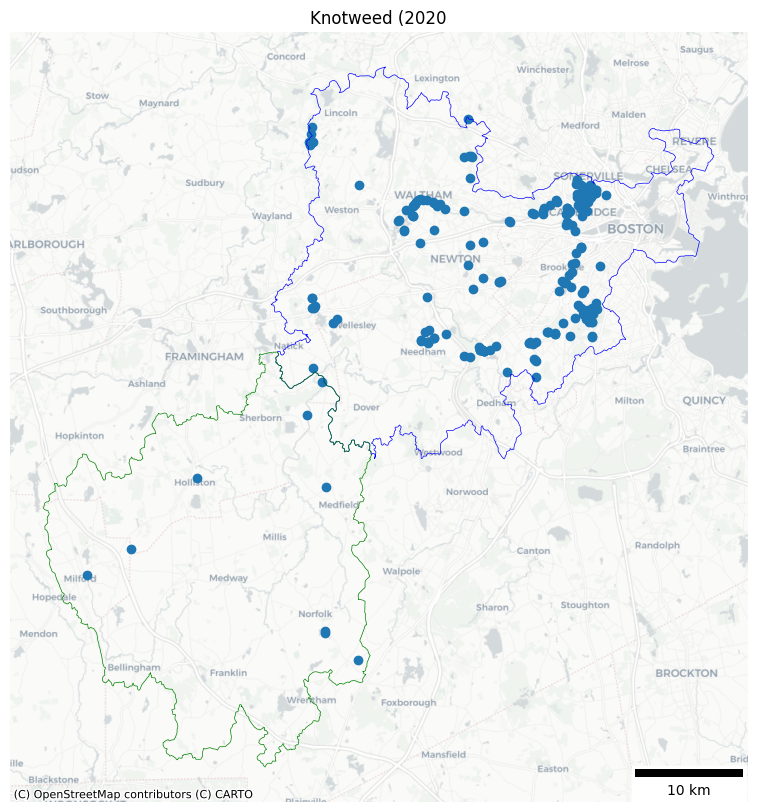

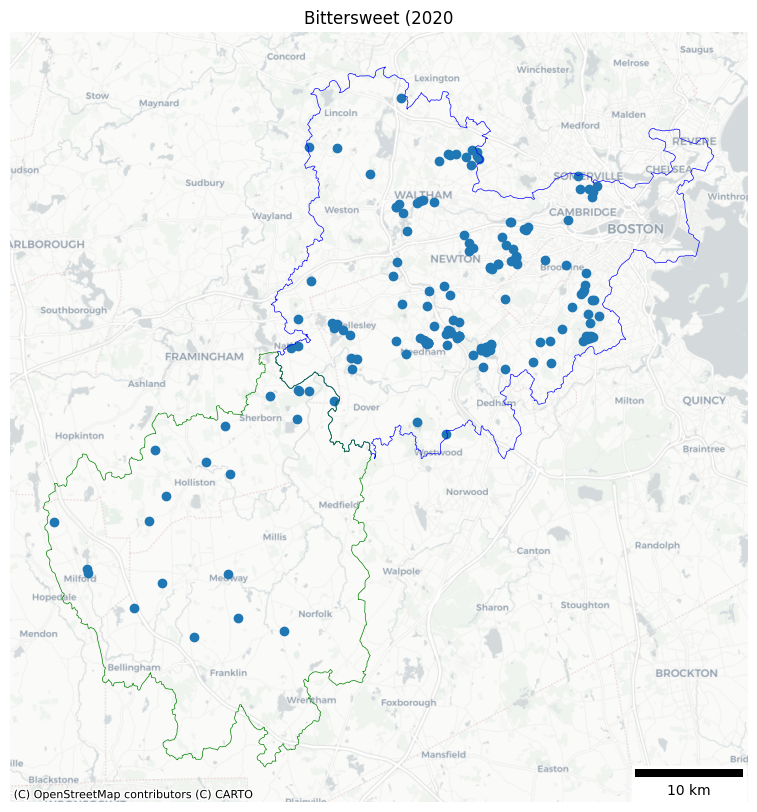

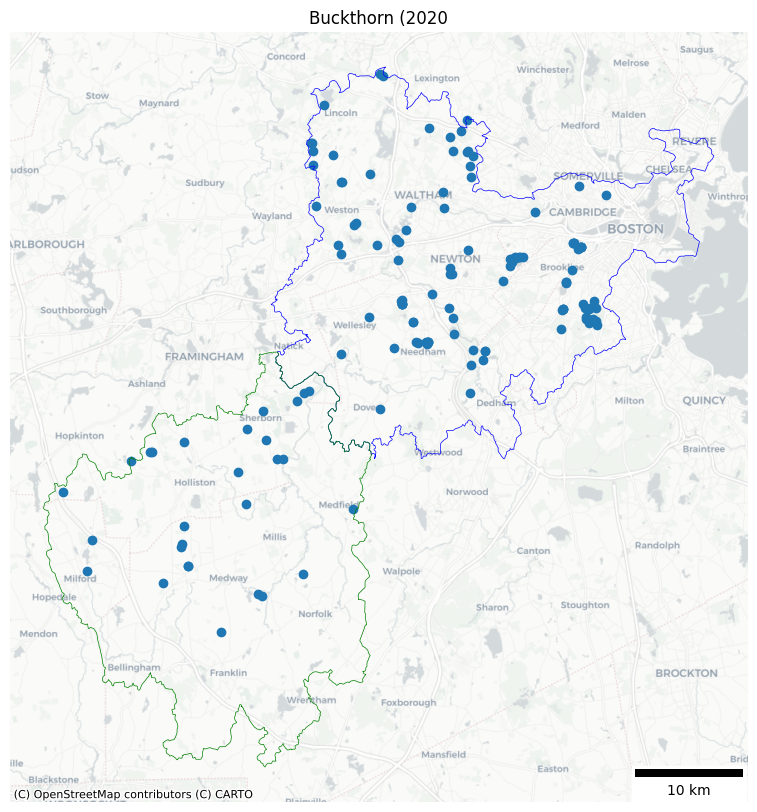

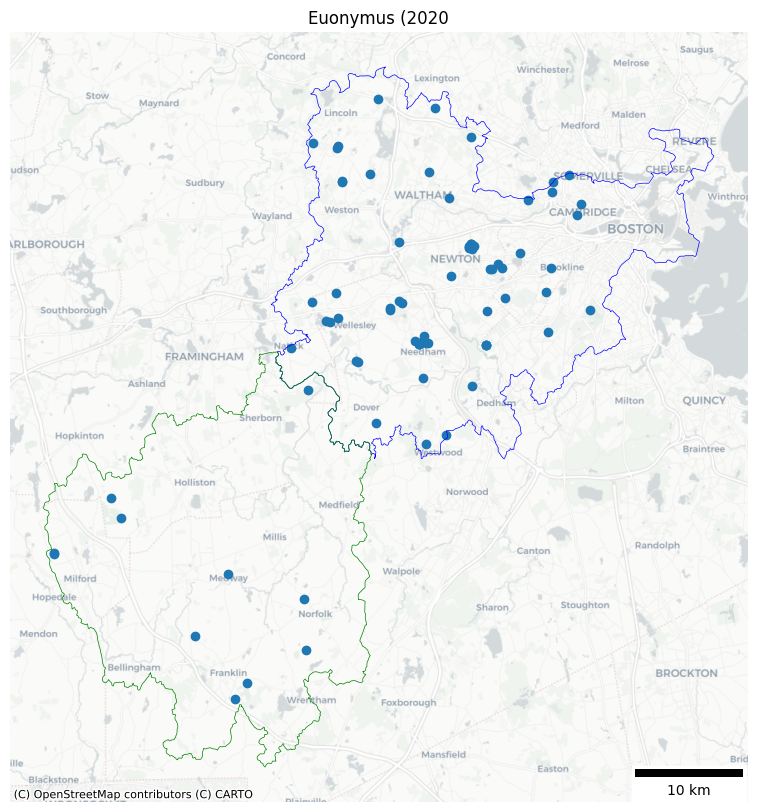

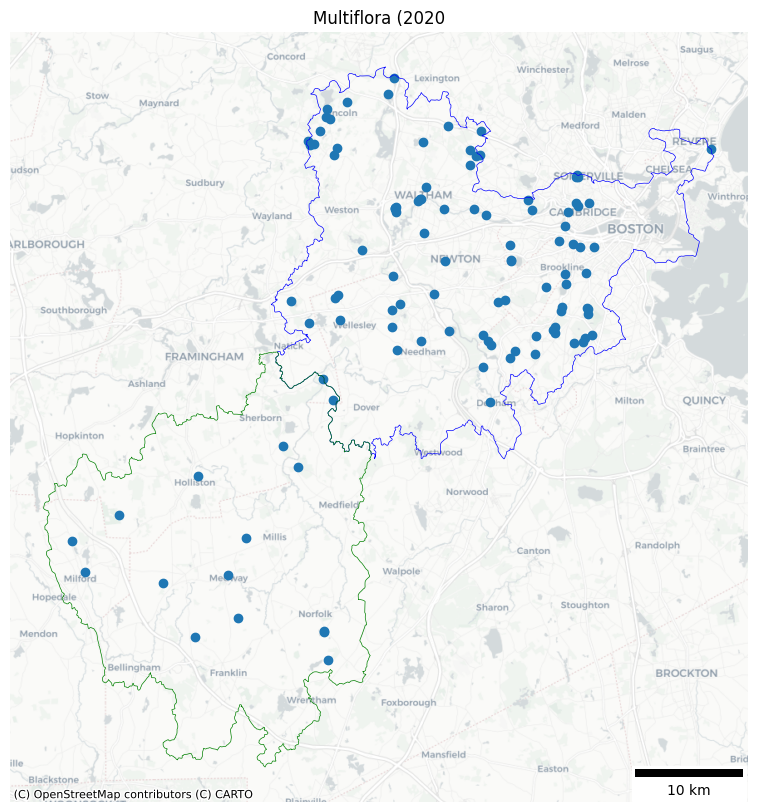

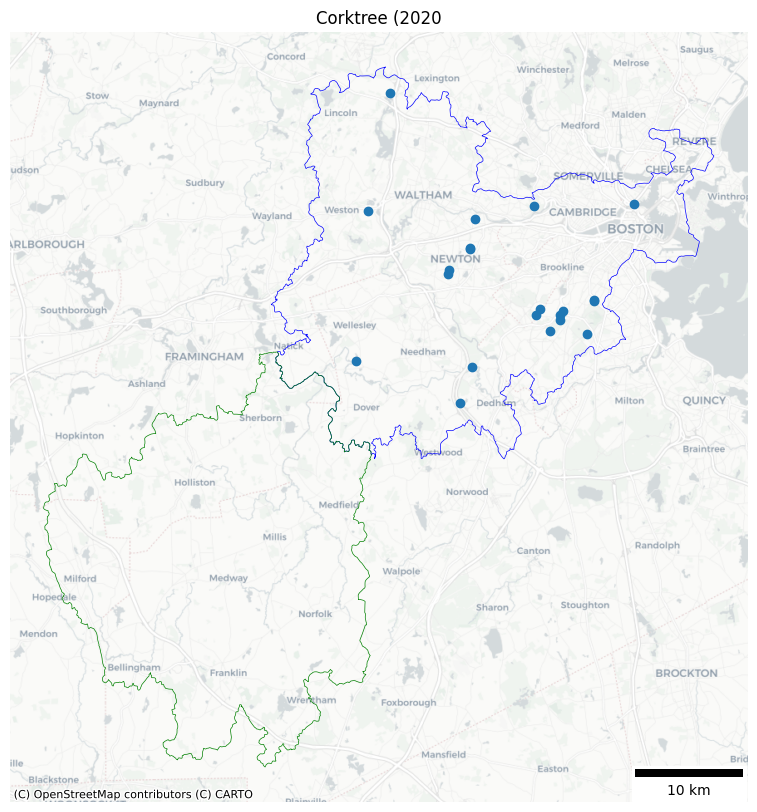

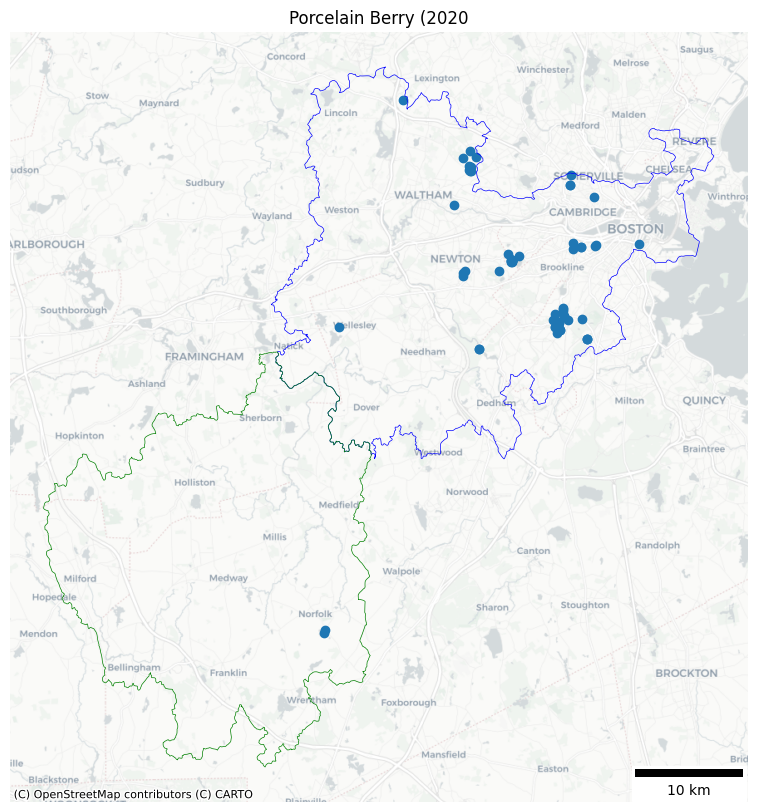

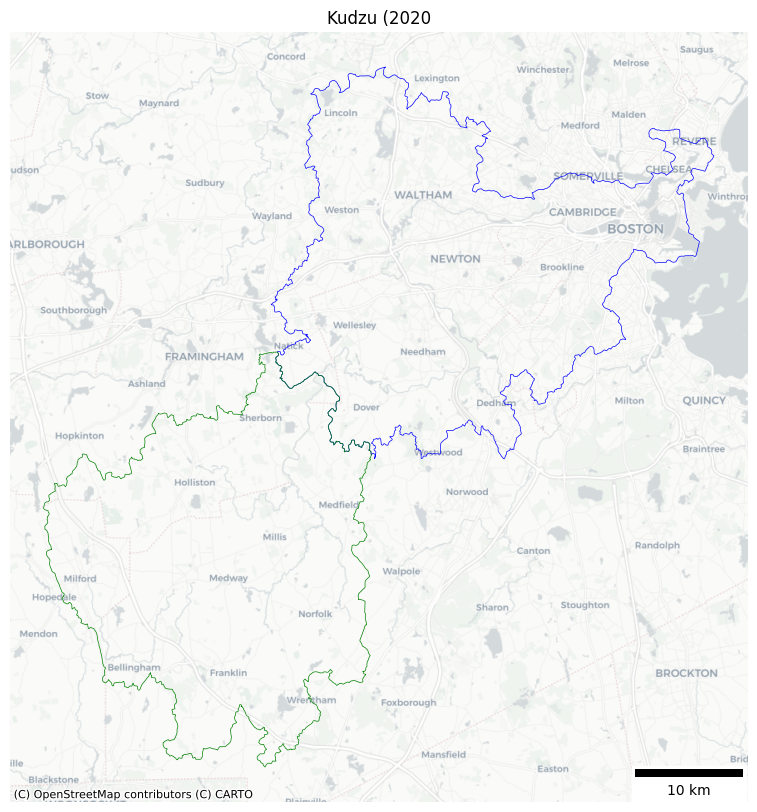

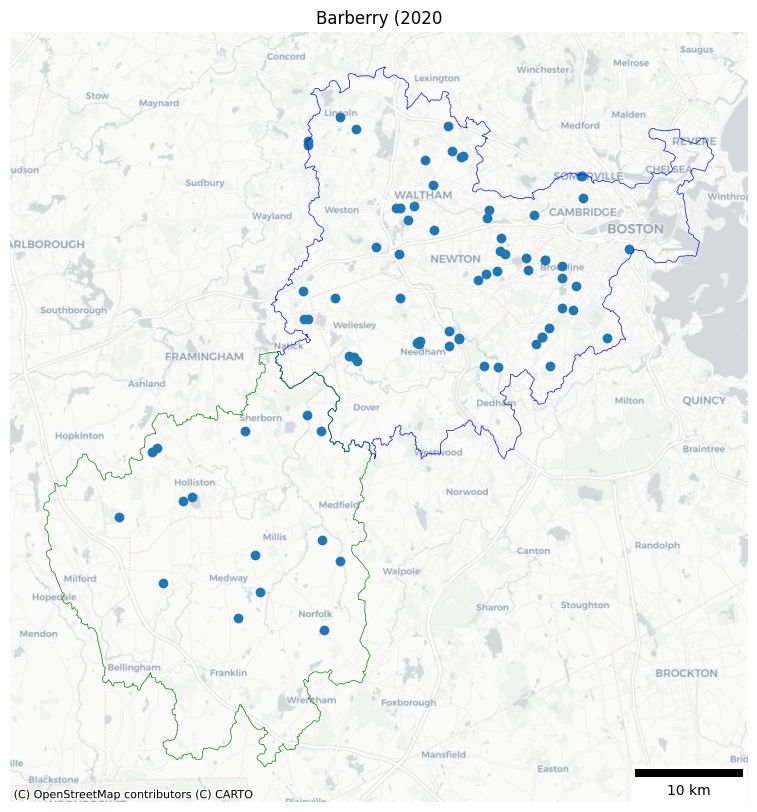

In [25]:
d={
  'Knotweed':knot_gdf,
  'Bittersweet':bitt_gdf,
  'Buckthorn':buck_gdf,
  'Euonymus':euon_gdf,
  'Multiflora':mult_gdf,
  'Corktree':cork_gdf,
  'Porcelain Berry':porc_gdf,
  'Kudzu':kudz_gdf,
  'Barberry':barb_gdf
}
for name, value in d.items():
  ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
  Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
  value.clip(Charles_gdf).to_crs(epsg=3857).plot(ax=ax)
  plt.title(name+" (2020")
  cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
  ax.set_axis_off()
  ax.add_artist(ScaleBar(1,location='lower right'))
  plt.savefig(name+'.png')

In [26]:
def extractPixel(image):
  return image.sample(test_point)

<IPython.core.display.HTML object>

In [27]:
coords=[barb_gdf.clip(Charles_gdf)['longitude'][96],barb_gdf.clip(Charles_gdf)['latitude'][96]]

<IPython.core.display.HTML object>

In [28]:
test_point=ee.Geometry.Point(coords)

<IPython.core.display.HTML object>

In [36]:
d_forest=NLCD2019lc.updateMask(NLCD2019lc.eq(41)).select('landcover')
d_forest_vec=d_forest.reduceToVectors(geometry=Charles,crs=d_forest.projection())

<IPython.core.display.HTML object>

In [40]:
map_3 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_3.add_layer(ee.Feature(d_forest_vec.first()))
map_3

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7c1052102350>

In [31]:
#Pre-processing sentinel-2 data
S2_All=ee.ImageCollection(("COPERNICUS/S2_SR_HARMONIZED")).filterDate('2019-01-01','2023-01-01').filterBounds(Charles.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)).map(mask_s2_clouds).map(Charclip).map(resample10m).map(addIndices).map(extractBandsIndices)

<IPython.core.display.HTML object>

In [32]:
NDVI_d_forest=pd.DataFrame(data=NDVI.getRegion(test_point,10).getInfo()[1:],columns=NDVI.getRegion(test_point,10).getInfo()[0])

<IPython.core.display.HTML object>

In [43]:
S2_TEST=pd.DataFrame(data=S2_All.getRegion(ee.Feature(d_forest_vec.first()).geometry(),10).getInfo()[1:],columns=S2_All.getRegion(ee.Feature(d_forest_vec.first()).geometry(),10).getInfo()[0])
date_format = "%m-%d-%Y"
S2_TEST['time'][0]=0
for i in np.arange(0,S2_TEST['id'].size-1):
  time_str1=str(S2_TEST['id'][i+1][4:6])+'-'+str(S2_TEST['id'][i+1][6:8])+'-'+str(S2_TEST['id'][i+1][:4])
  time_str2=str(S2_TEST['id'][0][4:6])+'-'+str(S2_TEST['id'][0][6:8])+'-'+str(S2_TEST['id'][0][:4])
  S2_TEST['time'][i+1]=(datetime.strptime(time_str1,date_format)-datetime.strptime(time_str2,date_format)).days
S2_TEST

<IPython.core.display.HTML object>

Streaming output truncated to the last 5000 lines.
<ipython-input-43-419541fecf4d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S2_TEST['time'][i+1]=(datetime.strptime(time_str1,date_format)-datetime.strptime(time_str2,date_format)).days
<ipython-input-43-419541fecf4d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S2_TEST['time'][i+1]=(datetime.strptime(time_str1,date_format)-datetime.strptime(time_str2,date_format)).days
<ipython-input-43-419541fecf4d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

id  longitude   latitude time  \
0      20190103T154641_20190103T155109_T18TYM -71.549150  42.184931    0   
1      20190103T154641_20190103T155109_T19TBG -71.549150  42.184931    0   
2      20190113T154611_20190113T155046_T18TYM -71.549150  42.184931   10   
3      20190113T154611_20190113T155046_T19TBG -71.549150  42.184931   10   
4      20190115T153609_20190115T153706_T18TYM -71.549150  42.184931   12   
...                                       ...        ...        ...  ...   
66182  20191129T154611_20191129T155035_T19TBG -71.546815  42.188075  330   
66183  20191219T154641_20191219T155110_T18TYM -71.546815  42.188075  350   
66184  20191219T154641_20191219T155110_T19TBG -71.546815  42.188075  350   
66185  20191224T154649_20191224T154843_T18TYM -71.546815  42.188075  355   
66186  20191224T154649_20191224T154843_T19TBG -71.546815  42.188075  355   

           NDVI  
0      0.559482  
1      0.616355  
2      0.565084  
3      0.695958  
4           NaN  
...         ...  
66182  0.480150  
66183  0.235628  
66184  0.299188  
66185  0.236658  
66186  0.308962  

[66187 rows x 5 columns]

<IPython.core.display.HTML object>

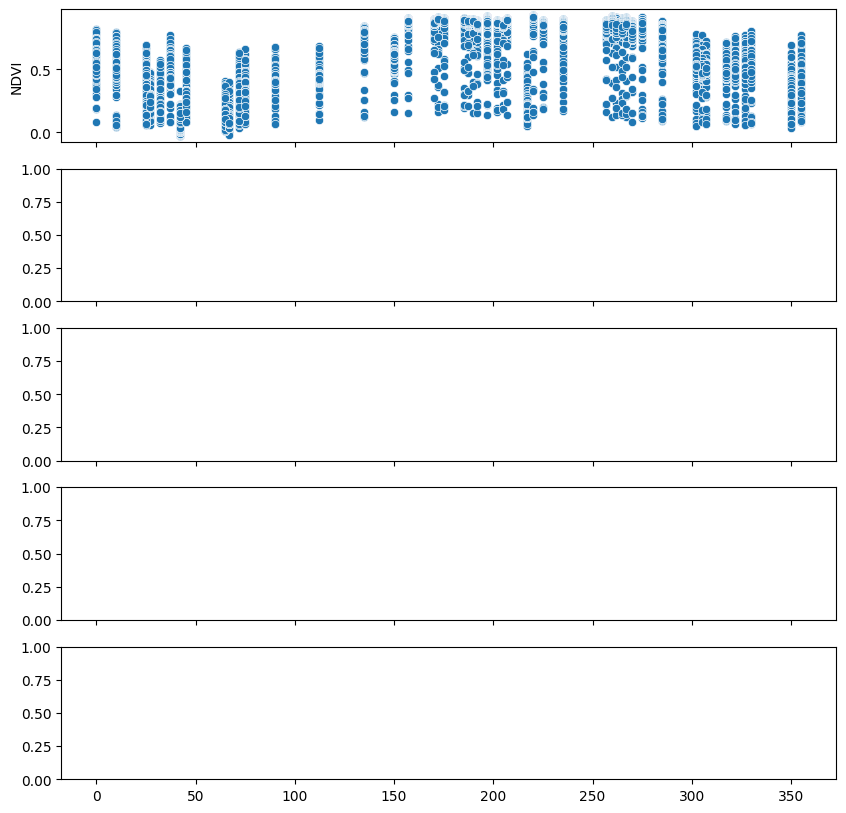

In [45]:
figure, axes = plt.subplots(5, 1, sharex=True,figsize=(10, 10))
sns.scatterplot(data=S2_TEST,x='time',y='NDVI',ax=axes[0])
plt.show()

In [ ]:
# Why do I get an error for some of the gifs I'm trying to generate but not others?
# How to extract pixel values from image collection so I can make time series graphs?
# How to get data stacked from my image collection into a matrix so I can run machine learning?



#Upsample if I want to make GIF